#  LIME [(Ribeiro .al 2016)](https://arxiv.org/abs/1602.04938)

## Intuition
*Intuitively, an explanation is a local linear approximation of the model's behaviour. While the model may be very complex globally, it is easier to approximate it around the vicinity of a particular instance. While treating the model as a black box, we perturb the instance we want to explain and learn a sparse linear model around it, as an explanation*

<p align="center">
<img src=https://raw.githubusercontent.com/marcotcr/lime/master/doc/images/lime.png width=400>
</p>

## Algorithm steps 
The different steps computed by the algorithm are the following :

### 1. Creation of a neighbourhood around the instance : 
- Data samples are generated by applying perturbations around the instance following a normal distribution
- A weight is allocated to every sample with regard to its proximity to the instance. This is the crucial step. The instance explanations may differ a lot with regard to the kernel used to compute the weights. 2 variables are at stake here, the kernel function and the kernel width :
  - the kernel function $k$ :
  $$k(d, k_w) = exp(\frac{-d^2}{k_w})$$ 
  where $$d = \sqrt{\sum_{i} (y_i - x_i)^2}$$
  - the kernel width $k_w$ :
$$k_w = 0.75*\sqrt{n_f}$$ 
with $n_f$ the number of features in the train set.

$k$ and $k_w$ are 2 parameters of our LIME function and can be customised.

An example of the impact of the kernel width on the instance explanation :

<p align="center">
<img src=https://christophm.github.io/interpretable-ml-book/images/lime-fail-1.png width=500>
</p>

### 2. Generate the samples labels 
Make black-box model predictions on the newly generated neighbourhood dataset to generate the associated labels.

### 3. Fit a linear model on the samples
A linear model is then fitted to this labeled data in order to generate our local linear model which corresponds to our instance explanation

# LIME for text

LIME for text data has one major difference with LIME for tabular data : the way the samples are generated and their weights computed. Let's take again the first step of the algorithm, illustrated with a YouTube comments Spam classification model.

|| CONTENT      | CLASS |
|-----------| ----------- | ----------- |
|267| PSY is a good guy      | 0       |
|173| For Christmas Song visit my channel! ;)   | 1        |

### 1. Creation of a neighbourhoods around the instance : 

- Data samples are generated by randomly removing some words from the instance text. The neighbourhood dataset is a dataset a binary features, where the value is 1 if the corresponding word is included and 0 if it has been removed.

| For |	Christmas	| Song |	visit |	my |	channel! |	;) |
| -- | -- | -- | -- | -- | -- | -- |
|1|0|1|1|0|0|1|
|0|1|1|1|1|0|1|
|1|0|0|1|1|1|1|
|1|0|1|1|1|1|1|
|0|1|1|1|0|0|1|

- A weight is allocated to every sample with regard to its proximity to the instance. With LIME for text, the weight is calculated with the same kernel than for tabular data, with a default kernel width of 25 (kernel width can be customised).

| For |	Christmas	| Song |	visit |	my |	channel! |	;) | weight |
| -- | -- | -- | -- | -- | -- | -- | -- |
|1|0|1|1|0|0|1|0.89|
|0|1|1|1|1|0|1|0.92|
|1|0|0|1|1|1|1|0.92|
|1|0|1|1|1|1|1|0.96|
|0|1|1|1|0|0|1|0.89|

### 2. Generate the samples labels 

- This second step is very close to the one for tabular data. The class 1 probability is calculated for every sample using the black-box model's predictions.

| For |	Christmas	| Song |	visit |	my |	channel! |	;) | weight | prob |
| -- | -- | -- | -- | -- | -- | -- | -- | -- |
|1|0|1|1|0|0|1|0.89|0.17|
|0|1|1|1|1|0|1|0.92|0.17|
|1|0|0|1|1|1|1|0.92|0.99|
|1|0|1|1|1|1|1|0.96|0.99|
|0|1|1|1|0|0|1|0.89|0.17|

### 3. Fit a linear model on the samples
- This third step remains the same, a linear model is then fitted to this labeled data in order to generate our local linear model which corresponds to our instance explanation.

# Now let's practice !

## Packages installation & Imports 

In [1]:
!pip install lime

import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 1.3 MB/s eta 0:00:0000:0100:01
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=30a8c6375e268e7eb37736e57c85837fd95e06a9084755200d3f84ec07204b0a
  Stored in directory: /Users/astel/Library/Caches/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


## Mount Drive (ONLY USE IF WORKING ON GOOGLE COLAB)
If working on Google Colab, you can modify the PATH to the folder on which you uploaded the data on your Drive.

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# PATH = "gdrive/MyDrive/data_folder/"

## Data Loading

Download the train.csv & test.csv datasets from github ([link](https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv))

In [18]:
df_train = pd.read_csv("train.csv", header=None)
df_test = pd.read_csv("test.csv", header=None)

## Columns name cleaning

In [23]:
df_train = df_train.rename(columns={0: 'target', 1: 'title', 2: 'description'})
df_test = df_test.rename(columns={0: 'target', 1: 'title', 2: 'description'})

df_train

,target,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


## TF-IDF Vectorizer & Logistic Regression 

In [24]:
#TF-IDF
tfidf_vc = TfidfVectorizer(
    min_df = 10, 
    max_features = 100000, 
    analyzer = "word", 
    ngram_range = (1, 2), 
    stop_words = 'english', 
    lowercase = True
)

# Logistic Regression
model = LogisticRegression(C = 0.5, solver = "sag")

# Pipeline definition
pipe = make_pipeline(tfidf_vc, model)

# Pipeline training
pipe.fit(df_train["description"], df_train.target)

# Predictions on test_set
test_pred = pipe.predict(df_test["description"])

## Evaluation

In [25]:
print(classification_report(df_test.target, test_pred))
print(confusion_matrix(df_test.target, test_pred))

              precision    recall  f1-score   support

           1       0.93      0.90      0.92      1900
           2       0.95      0.98      0.96      1900
           3       0.88      0.87      0.88      1900
           4       0.88      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600

[[1717   57   74   52]
 [  19 1858   15    8]
 [  63   21 1652  164]
 [  52   24  133 1691]]


## Explicability with LIME

In [30]:
idx = 42

class_names = ["World", "Sports", "Business", "Sci/Tech"]
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(
    df_test["description"][idx], 
    pipe.predict_proba,
    num_features = 10, 
    top_labels=3
)

exp.show_in_notebook(text=df_test["description"][idx])

# LIME for image

LIME algorithm for images works a little differently than for tabular data and text. Indeed, perturbing individual pixels one by one will not really change the prediction because more than one pixel contribute to one class. 



## Algorithm steps 
The different steps computed by the algorithm are the following :

### 1. Creation of superpixels : 
The alorithm first requires to generate "superpixels" which are composed of contigous pixels that share properties such as texture or color distribution.This step is crucial for the generation of the LIME explanation since perturbation of superpixels is used to identify which of the image areas has been relevant for a specific class decision.

LIME uses the quickshift algorithm to produce these superpixels (more details here : https://www.robots.ox.ac.uk/~vedaldi/assets/pubs/vedaldi08quick.pdf)

<p align="center">
<img src=https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/figure3-2cea505fe733a4713eeff3b90f696507.jpg width=500>
</p>


### 2. Generate perturbed instances :
Once the superpixels are defined, we can generate a new dataset of perturbed instances by turning off superpixels on the image. The interpretable representation of the image is a binary vector where 1 indicates the original super-pixel and 0 indicates a grayed out super-pixel.

### 3. Fit a linear model on the samples

We can now fit a linear model on the perturbed instance to a specific class and highlight the superpixels with positive or negative weight towards a specific class.

<p align="center">
<img src=https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/figure4-99d9ea184dd35876e0dbae81f6fce038.jpg width=500>
</p>


# Now let's practice !

## Packages installation & Imports 






In [8]:
from tensorflow import keras

from keras.applications import inception_v3 as inc_net
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries


## Load pre-trained InceptionV3 model and images

In [9]:
# Load model
inception_model = InceptionV3(weights='imagenet')

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [12]:
# Image processing
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

images = transform_img_fn(["silly_dog.jpg"])

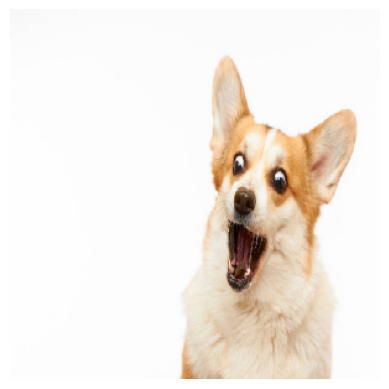

In [13]:
# display the image
plt.imshow(images[0] / 2 + 0.5)
plt.axis('off')
plt.show()

## Make some predictions

In [14]:
# decode the results into a list of tuples (class, description, probability)
preds = inception_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
('n02113023', 'Pembroke', np.float32(0.88389385))
('n02113186', 'Cardigan', np.float32(0.04401234))
('n04584207', 'wig', np.float32(0.0023998432))
('n02119022', 'red_fox', np.float32(0.0008062129))
('n03935335', 'piggy_bank', np.float32(0.0007448323))


## Explicability with LIME image

In [15]:
# Train lime image explainer
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), inception_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

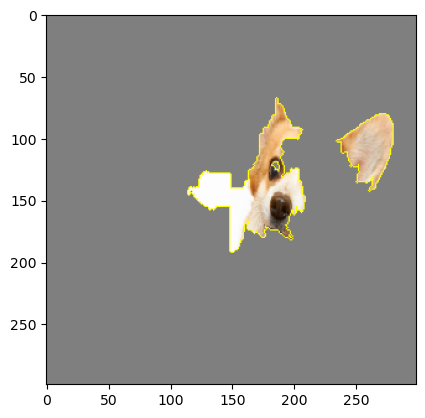

In [21]:
# Plot boundaries
selected_label = 1
temp, mask = explanation.get_image_and_mask(explanation.top_labels[selected_label], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

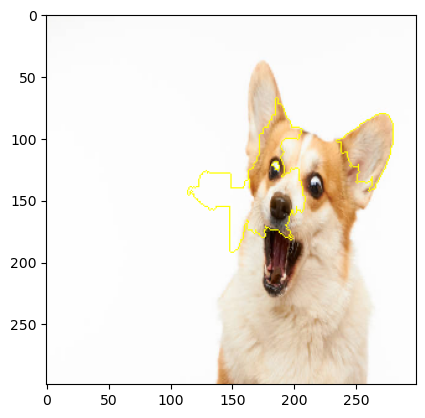

In [22]:
# Plot boundaries on the full image
temp, mask = explanation.get_image_and_mask(explanation.top_labels[selected_label], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

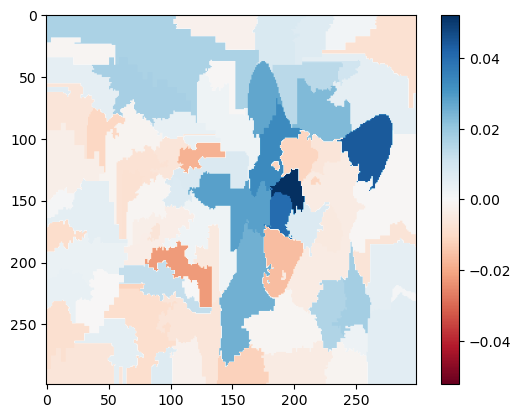

In [23]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[selected_label]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

# **SH**apley **A**dditive ex**P**lanations ([Lundberg et .al 2017](https://arxiv.org/abs/1905.04610))

## From Game Theory


* In game theory, the [Shapley value](https://en.wikipedia.org/wiki/Shapley_value) (1953) is a solution concept of fairly distributing both gains and costs to several actors working in coalition.
* The Shapley value applies primarily in situations when the contributions of each actor are unequal, but they work in cooperation with each other to obtain the payoff.

You first start by identifying each player’s contribution when they play individually, when 2 play together, and when all 3 play together.
<p align="center">
<img src=https://clearcode.cc/wp-content/uploads/2016/11/ABC-wide.png?ver=1478561348 width=500>
</p>

Then, you need to consider all possible orders and calculate their marginal value – e.g. what value does each player add when player A enters the game first, followed by player B, and then player C.
Below are the 6 possible orders and the marginal value each player adds in the different combinations:
<p align="center">
<img src=https://clearcode.cc/wp-content/uploads/2016/11/ABC-updated.png?ver=1479258642 width=500>
</p>

Now that we have calculated each player’s marginal value across all 6 possible order combinations, we now need to add them up and work out the Shapley value (i.e. the average) for each player.

<ins>Example for Player A:</ins>
$ \text{Shapley}_{value} = \frac{7+7+10+3+9+10}{6} \approx 7.7$

Computing the Shapley value for each player will give the true contribution each player made to the game and assign credit fairly

## To Explainability Method

* Each value of an independent variable or a feature for a given sample is a part of a cooperative game where we assume that prediction is actually the payout.
* Shapley values correspond to the contribution of each feature towards pushing the prediction away from the expected value.

Let take an example of a local prediction of a house price and see how the different features are impacting the prediction. 
<p align="center">
<img src=https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_waterfall.png width=700>
</p>

Example of features definition: 
* LSTAT (% of lower status population)
* RM (average number of rooms per house in an area)
* NOX (nitric oxides concentration)
* RAD (index of accessibility to radial highways)
* For more information, link to [Boston dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) 


## Explanation of SHAP through visualization

### Global explainability & local explanation summary
<p align="center">
<img src=https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_global_bar.png width=470>
<img src=https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_beeswarm.png width=530>
</p>

### Local explainability and correlation
<p align="center">
<img src=https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/boston_scatter.png width=500>
</p>

## Advantages
* SHAP has a solid theoretical foundation in game theory. The prediction is fairly distributed among the feature values. We get contrastive explanations that compare the prediction with the average prediction.
* SHAP connects LIME and Shapley values.
* SHAP has a fast implementation for tree-based models.
* When computation of the many Shapley values is possible, global model interpretations can be built. The global interpretation methods include feature importance, feature dependence, interactions, clustering and summary plots.

## Drawbacks
* Slow computation if you want to compute Shapley values for many instances (except for tree-based models).
* The disadvantages of Shapley values also apply to SHAP: Shapley values can be misinterpreted.
* Since every model is trained from observational data, it is not necessarily a causal model.

For more information on SHAP values see: https://github.com/slundberg/shap

## Practical exercise

Download the dataset from Kaggle ([link](https://www.kaggle.com/paololol/league-of-legends-ranked-matches))

The objective in a game of League of Legends is to destroy the enemy base, in a 5 vs. 5 match. Using datasets with statistics of the game and the players, the goal is to predict the probability to win the game. 

In [24]:
import pandas as pd
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt

shap.initjs()

AttributeError: `np.obj2sctype` was removed in the NumPy 2.0 release. Use `np.dtype(obj).type` instead.

In [ ]:
# read in the data
matches = pd.read_csv(PATH+"matches.csv")
participants = pd.read_csv(PATH+"participants.csv")
stats1 = pd.read_csv(PATH+"stats1.csv", low_memory=False)
stats2 = pd.read_csv(PATH+"stats2.csv", low_memory=False)
stats = pd.concat([stats1,stats2])

In [ ]:
# merge into a single DataFrame
a = pd.merge(participants, matches, left_on="matchid", right_on="id")
allstats_orig = pd.merge(a, stats, left_on="matchid", right_on="id")
allstats = allstats_orig.copy()

# drop games that lasted less than 10 minutes
allstats = allstats.loc[allstats["duration"] >= 10*60,:]

# Convert string-based categories to numeric values
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype('category')
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

# Reduce dataset size to accelerate training
allstats = allstats[allstats['matchid'] < 50000]

X = allstats.drop(["win"], axis=1)
y = allstats["win"]

In [ ]:
# convert all features we want to consider as rates
rate_features = [
    "kills", "deaths", "assists", "killingsprees", "doublekills",
    "triplekills", "quadrakills", "pentakills", "legendarykills",
    "totdmgdealt", "magicdmgdealt", "physicaldmgdealt", "truedmgdealt",
    "totdmgtochamp", "magicdmgtochamp", "physdmgtochamp", "truedmgtochamp",
    "totheal", "totunitshealed", "dmgtoobj", "timecc", "totdmgtaken",
    "magicdmgtaken" , "physdmgtaken", "truedmgtaken", "goldearned", "goldspent",
    "totminionskilled", "neutralminionskilled", "ownjunglekills",
    "enemyjunglekills", "totcctimedealt", "pinksbought", "wardsbought",
    "wardsplaced", "wardskilled"
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60 # per minute rate

# convert to fraction of game
X["longesttimespentliving"] /= X["duration"]

# define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets"
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

In [ ]:
# create train/validation split
Xt, Xv, yt, yv = train_test_split(X,y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

In [ ]:
# We want to solve a logistic regression with a logloss evaluation
params = {
    "eta": 0.5,
    "max_depth": 4,
    "objective": # TO FILL,
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": # TO FILL
}
# Code the training part for 300 iterations with early stopping rounds at 5 and a verbose eval at 25
model = xgb.train(params, dt, [(dt, "train"),(dv, "valid")], # TO FILL)

In [ ]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(# TO FILL)
shap_values = #TO_FILL.shap_values(Xv)

In [ ]:
# Force plot example for a record
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], Xv.iloc[0,:])

In [ ]:
xs = np.linspace(-4,4,100)
plt.xlabel("Log odds of winning")
plt.ylabel("Probability of winning")
plt.title("How changes in log odds convert to probability of winning")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

In [ ]:
# Global explainability
shap.plots.bar(explainer(Xv))

In [ ]:
# Local explanation summary
shap.summary_plot(shap_values, Xv)

In [ ]:
# Dependence plot between variables (automatic)
shap.dependence_plot("Gold earned per min.", shap_values, Xv)

In [ ]:
# Dependence plot between variables (assigned)
shap.dependence_plot("Gold earned per min.", shap_values, Xv, alpha=0.2, interaction_index="Deaths per min.")

In [ ]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(3):
    shap.dependence_plot(top_inds[i], shap_values, Xv)

In [ ]:
# Play with plot variables
shap.dependence_plot(top_inds[9], shap_values, Xv, x_jitter=#TO FILL, alpha=#TO FILL, dot_size=#TO FILL)